In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

%matplotlib inline

In [2]:
from __future__ import print_function, division

import nsfg
import first

In [3]:
preg = nsfg.ReadFemPreg()
preg.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


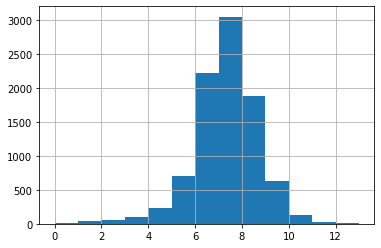

In [4]:
preg.birthwgt_lb.hist(bins=np.arange(0,14))

In [5]:
pd.cut(preg.birthwgt_lb, bins=np.arange(0,14)).value_counts()

(6, 7]      3049
(5, 6]      2223
(7, 8]      1889
(4, 5]       697
(8, 9]       623
(3, 4]       229
(9, 10]      132
(2, 3]        98
(1, 2]        53
(0, 1]        40
(10, 11]      26
(11, 12]      10
(12, 13]       3
Name: birthwgt_lb, dtype: int64

In [6]:
preg.birthwgt_lb.value_counts()
# Interestingly, above the histogram and pd.cut do not return the same results.
# For the histogram it appears that the edge values are included in the 'right' bin
# For example all the 7s are included in the 7,8 bin
# However in pd.cut the edge values go into the 'left' bin

7.0     3049
6.0     2223
8.0     1889
5.0      697
9.0      623
4.0      229
10.0     132
3.0       98
2.0       53
1.0       40
11.0      26
12.0      10
0.0        8
13.0       3
14.0       3
15.0       1
Name: birthwgt_lb, dtype: int64

In [7]:
# If we pass right = False then we get the same result as the histogram
pd.cut(preg.birthwgt_lb, bins=np.arange(0,14), right=False).value_counts()

[7, 8)      3049
[6, 7)      2223
[8, 9)      1889
[5, 6)       697
[9, 10)      623
[4, 5)       229
[10, 11)     132
[3, 4)        98
[2, 3)        53
[1, 2)        40
[11, 12)      26
[12, 13)      10
[0, 1)         8
Name: birthwgt_lb, dtype: int64

### Trying some hypothesis testing

In [8]:
# same answer as in book for example in section 9.2
stats.binom_test(140,250)

0.06642115124004863

In [9]:
live, firsts, others = first.MakeFrames()

In [10]:
firsts_prglngth = firsts.prglngth.values
others_prglngth = others.prglngth.values

In [11]:
# same as answer in book, section 9.3
result = stats.ttest_ind(firsts.prglngth.values, others.prglngth.values)
result

Ttest_indResult(statistic=1.3802152088125652, pvalue=0.16755412639415004)

In [12]:
# Try with data reversed, same thing except statistic is negative
# Note that to do a one-tailed test it is only necessary to divide the p-value by 2 (section 9.4)
result2 = stats.ttest_ind(others.prglngth.values, firsts.prglngth.values)
result2

Ttest_indResult(statistic=-1.3802152088125652, pvalue=0.16755412639415004)

In [13]:
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [14]:
def CorrelationRandCI(x, y, alpha=0.05, method='pearson'):
    ''' Calculate a correlation coefficient and its confidence interval for two data sets.
    
    Args:
        x, y {array-like} -- Input data sets
        alpha {float} -- Significance level (default: 0.05)
        method {string} -- Select 'pearson' or 'spearman' method (default: 'pearson')
   
    Returns:
        r {float} -- The correlation coefficient
        p {float} -- The corresponding p value
        lo, hi {float} -- The lower and upper bounds of the confidence interval
    '''

    if method == 'pearson':
        r, p = stats.pearsonr(x,y)
    elif method == 'spearman':
        r, p = stats.spearmanr(x,y)
    else:
        raise Exception('Must enter either pearson or spearman as a string for method argument')

    r_z = np.arctanh(r)
    stderr = 1 / np.sqrt(len(x) - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    low_z, high_z = r_z - (z * stderr), r_z + (z * stderr)
    low, high = np.tanh((low_z, high_z))
    return r, p, low, high

In [15]:
agepreg = live.agepreg.values
wgt = live.totalwgt_lb.values

In [16]:
# This corresponds with what is explained in the book in section 9.5: "r is 0.07 and p approaches zero"
# Question: how could we do randomized simulations to compare the r value as done in the book?: got highest of 0.04
CorrelationRandCI(agepreg, wgt)

(0.0688339703541091,
 5.722947107252811e-11,
 0.04828563698428594,
 0.08932406444362938)

In [17]:
# Try a randomization, this works just fine for doing simulations, and gave a similar result as in the book
# This appends the r value in the results
results = []
for _ in range(1000):
    agepreg2 = np.random.permutation(agepreg)
    r = CorrelationRandCI(agepreg2, wgt)
    results.append(r[0])

In [18]:
# The max results for r value after 1000 simulations
# Since after 1000 simulations we cannot get an r value as high as the one from our data this shows statistical significance
max(results)

0.027231796423124458

In [19]:
# Try proportion one too (section 9.6)
# The book first does a total deviation method and then this chisquare method
# The one below matches with the chisquare method in the book
results = stats.chisquare([8,9,19,5,8,11])
results

Power_divergenceResult(statistic=11.6, pvalue=0.040699388504049985)

In [20]:
# Try randomization method for difference in means test from section 9.3 too
# The basic idea here is to pool all the data, then run many iterations on it by randomizing, splitting, and comparing
# Then finally we can check what the most extreme value is that we get and compare that with the p-value from our original data
# The purpose of this is to see what kind of results we get from a null hypothesis case
firsts_prglngth = firsts.prglngth.values
others_prglngth = others.prglngth.values
first_size = len(firsts_prglngth)
other_size = len(others_prglngth)
pooled_data = np.hstack((firsts_prglngth, others_prglngth))
first_size, other_size

(4413, 4735)

In [21]:
pvalue_results = []
for _ in range(1000):
    np.random.shuffle(pooled_data)
    group1 = pooled_data[:first_size]
    group2 = pooled_data[first_size:]
    result = stats.ttest_ind(group1, group2)
    pvalue_results.append(result.pvalue)

In [22]:
min(pvalue_results)

0.001467905990792668

In [23]:
# In the end the above randomization for section 9.3 (difference in means) to obtain min pvalue doesn't show us anything
# The reason for this I think is that doing 1000 randomized trials like this will of course yield a wide range of pvalues
# After 1000 trails it is natural that you would get some low results and some high results
# What needs to be compared here is the test statistic, not the p-value, as I did above with the r values
# The test statistic in this case is the abs diff in means
# Try again
diff_mean_orginal = abs(firsts_prglngth.mean() - others_prglngth.mean())
diff_mean_orginal

0.07803726677754952

In [24]:
diff_mean_results = []
for _ in range(10):
    np.random.shuffle(pooled_data)
    group1 = pooled_data[:first_size]
    group2 = pooled_data[first_size:]
    result = abs(group1.mean() - group2.mean())
    diff_mean_results.append(result)

In [25]:
max(diff_mean_results)

0.07168912239947645

In [26]:
# The above shows that I can get far higher differences in mean from randomized samples compared with the original data one
# Even when the number of simulations is reduced quite low I can still easily get higher values
# This demonstrates further that the difference in means is not statistically significant

In [27]:
# Try my diffmeansrandomization function
def DiffMeansRandomization(a, b, iters=1000):
    
    # Combine the two data sets
    a_size = len(a)
    pooled_data = np.hstack((a, b))

    # Calculate the difference in means of randomized samples from the pooled data
    diff_mean_results = []
    for _ in range(iters):
        np.random.shuffle(pooled_data)
        group1 = pooled_data[:a_size]
        group2 = pooled_data[a_size:]
        result = abs(group1.mean() - group2.mean())
        diff_mean_results.append(result)
    
    return max(diff_mean_results)

In [28]:
# It's working
max_diff = DiffMeansRandomization(firsts_prglngth, others_prglngth, iters=10)
max_diff

0.1275082667103149

In [29]:
# test function with new one-sided option
def DiffMeansRandomization(a, b, iters=1000, onesided=False, seed=123):
    """Generates a list of differences in means of two data sets from randomized simulations.
       Can then use the 'max' built-in to find what the most extreme value is.

    Args:
        a (array-like): Input data set 1
        b (array-like): Input data set 2
        iters (int, optional): The number of simulations to run (Defaults to 1000)
        onesided (bool): If set to True a onesided test is run, not using absolute value of difference (defaults to False) 

    Returns:
        list: The differences in means from the simulations
    """
    # set seed
    np.random.seed(seed)
        
    # Combine the two data sets
    a_size = len(a)
    pooled_data = np.hstack((a, b))

    # Calculate the difference in means of randomized samples from the pooled data
    diff_mean_results = []
    
    if onesided == False:
        for _ in range(iters):
            np.random.shuffle(pooled_data)
            group1 = pooled_data[:a_size]
            group2 = pooled_data[a_size:]
            result = abs(group1.mean() - group2.mean())
            diff_mean_results.append(result)
        print(1)
    
    elif onesided == True:
        for _ in range(iters):
            np.random.shuffle(pooled_data)
            group1 = pooled_data[:a_size]
            group2 = pooled_data[a_size:]
            result = group1.mean() - group2.mean()
            diff_mean_results.append(result)
        print(2)
    
    else:
        raise TypeError('\'onesided\' parameter only accepts Boolean True or False')
    
    return diff_mean_results

In [30]:
DiffMeansRandomization(firsts_prglngth, others_prglngth, iters=10, onesided=True)

2


[-0.0007660959471991191,
 -0.03403862687542869,
 -0.016964564951727823,
 -0.0870119984848472,
 -0.0541772640161966,
 0.03907338187475773,
 0.01236779784026254,
 0.02199931995105686,
 -0.03929218439041193,
 -0.0033928747046871877]

In [31]:
DiffMeansRandomization(firsts_prglngth, others_prglngth, iters=10)

1


[0.0007660959471991191,
 0.03403862687542869,
 0.016964564951727823,
 0.0870119984848472,
 0.0541772640161966,
 0.03907338187475773,
 0.01236779784026254,
 0.02199931995105686,
 0.03929218439041193,
 0.0033928747046871877]

In [32]:
DiffMeansRandomization(firsts_prglngth, others_prglngth, iters=10, onesided=True)

2


[-0.0007660959471991191,
 -0.03403862687542869,
 -0.016964564951727823,
 -0.0870119984848472,
 -0.0541772640161966,
 0.03907338187475773,
 0.01236779784026254,
 0.02199931995105686,
 -0.03929218439041193,
 -0.0033928747046871877]

In [33]:
# Raise an error
# DiffMeansRandomization(firsts_prglngth, others_prglngth, iters=10, onesided='yes')

In [34]:
# section 9.8 first babies chisquared case
# First build rv from pooled prglngth lists and uses this generate the expected probabilites for 35 - 43 weeks
# Then use rvs to generate values for observed and use the probs from above to generate expected
# These then go into the chisquare test
# stats.chisquare()

In [35]:
def DiscreteRv(a):
    """Creates a scipy.stats discrete_rv.

    Arguments:
        a {array-like} -- a single data set, will be flattened if it is not already 1-D

    Returns:
        An instance of scipy.stats discrete_rv representing the input data
    """
    val,cnt = np.unique(a, return_counts=True)
    
    return stats.rv_discrete(values=(val,cnt/sum(cnt)))

In [36]:
pooled_rv = DiscreteRv(pooled_data)
values = range(35,44)

In [37]:
expected_probs = pooled_rv.pmf(values)

In [38]:
firsts_rv = DiscreteRv(firsts_prglngth)
others_rv = DiscreteRv(others_prglngth)

firsts_probs = firsts_rv.pmf(values)
others_probs = others_rv.pmf(values)

firsts_obs = firsts_probs * len(firsts_prglngth)
others_obs = others_probs * len(others_prglngth)

firsts_exp = expected_probs * len(firsts_prglngth)
others_exp = expected_probs * len(others_prglngth)

In [39]:
firsts_chi = stats.chisquare(firsts_obs, firsts_exp)
others_chi = stats.chisquare(others_obs, others_exp)

In [40]:
firsts_chi

Power_divergenceResult(statistic=52.537079057170516, pvalue=1.3253907962535425e-08)

In [41]:
others_chi

Power_divergenceResult(statistic=48.96433577176214, pvalue=6.458646999054618e-08)

In [42]:
# This worked to give the same value as in the book: 102 for the chisquared test statistic
firsts_chi.statistic + others_chi.statistic

101.50141482893265

In [43]:
# To match with the book, the final part would be to run the iterations of the same calculations on the null hypothesis model
# I decided not to do this though

In [44]:
# Trying with some khanacademy questions
exp = [16,20,16,16,12]
obs = [16,11,16,18,19]
stats.chisquare(obs, exp)

Power_divergenceResult(statistic=8.383333333333333, pvalue=0.07850351401595175)

In [45]:
exp = [94,24,82]
obs = [90,21,89]
stats.chisquare(obs, exp)

Power_divergenceResult(statistic=1.1427737415672028, pvalue=0.5647416716086866)

In [46]:
exp = [75,45,15,15]
obs = [75,55,15,5]
stats.chisquare(obs, exp)

Power_divergenceResult(statistic=8.88888888888889, pvalue=0.03080523378048964)

In [47]:
exp = [8,8,20,36,8]
obs = [12,4,20,36,8]
stats.chisquare(obs, exp)

Power_divergenceResult(statistic=4.0, pvalue=0.40600584970983794)

In [48]:
# More Khanacademy questions
stats.chi2_contingency([[38,7,3],[162,53,37]])

(4.327876984126984,
 0.11487180723651062,
 2,
 array([[ 32. ,   9.6,   6.4],
        [168. ,  50.4,  33.6]]))

In [49]:
stats.chi2_contingency([[8,10],[28,61],[39,29],[75,50]])

(18.928765513696113,
 0.00028282921547299954,
 3,
 array([[ 9. ,  9. ],
        [44.5, 44.5],
        [34. , 34. ],
        [62.5, 62.5]]))

In [50]:
stats.chi2_contingency([[6,78],[9,55],[15,133],[6,58]])

(1.9662966537966542,
 0.5794313456996103,
 3,
 array([[  8.4,  75.6],
        [  6.4,  57.6],
        [ 14.8, 133.2],
        [  6.4,  57.6]]))

In [51]:
stats.chi2_contingency([[30,25,15],[20,5,5]])

(5.158730158730159,
 0.07582212977799092,
 2,
 array([[35., 21., 14.],
        [15.,  9.,  6.]]))

In [52]:
# Testing my proportion hypothesis functions
def TwoSampleZtestForProportion(p1, n1, p2, n2, hyp_diff = 0):
    """A two-tailed, two-sample Z-test for difference between two sample proportions.
    The test measures whether the proportions differ significantly across samples.

    Args:
        p1 (float): The first sample proportion
        n1 (int): The first sample size
        p2 (float): The second sample proportion
        n2 (int): The second sample size
        hyp_diff (float): The hypothesized difference between the proportions of the samples (defaults to 0) 

    Returns:
        z (float): The z-score
        p_value (float): The p_value (two-tailed)
    """
    
    p_total = (p1*n1 + p2*n2) / (n1 + n2)

    z = ((p1 - p2) - hyp_diff) / np.sqrt(p_total * (1-p_total) * ((1/n1) + (1/n2)))
    p_value = 2 * (1 - stats.norm.cdf(z))

    return z, p_value

In [53]:
TwoSampleZtestForProportion(.21, 195, .58, 605)

(-8.988182555020416, 2.0)

In [54]:
def OneSampleZtestForProportion(p, p_pop, n):
    """A two-tailed, one-sample Z-test for a proportion.
    The test measures whether an observed proportion differs from a population proportion.

    Args:
        p (float): The sample proportion
        p_pop (float): The population proportion
        n (int): The sample size

    Returns:
        z (float): The z-score
        p_value (float): The p_value (two-tailed)
    """
    z = abs(p - p_pop) / np.sqrt(p_pop * (1 - p_pop) / n)
    p_value = 2 * (1 - stats.norm.cdf(z))

    return z, p_value

In [55]:
OneSampleZtestForProportion(.45,.50,1000)

(3.1622776601683786, 0.0015654022580025018)

In [56]:
OneSampleZtestForProportion(.274, .20, 62)

(1.4566914566921851, 0.14520156911789295)

In [59]:
df_test = pd.DataFrame(np.array(range(36)).reshape(6,6))
df_test

,0,1,2,3,4,5
0,0,1,2,3,4,5
1,6,7,8,9,10,11
2,12,13,14,15,16,17
3,18,19,20,21,22,23
4,24,25,26,27,28,29
5,30,31,32,33,34,35


### Try some statsmodels confidence intervals and hypothesis tests

In [61]:
import statsmodels.api as sm

In [62]:
sm.stats.proportions_ztest(82,100,.9, prop_var=.9)

(-2.666666666666669, 0.00766076113517941)

In [64]:
# Difference in means test, same result as scipy from above:
# Ttest_indResult(statistic=1.3802152088125652, pvalue=0.16755412639415004)
sm.stats.ttest_ind(firsts.prglngth.values, others.prglngth.values)

(1.3802152088125645, 0.1675541263941503, 9146.0)